In [2]:
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt
import awkward as ak
from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

#####
#Delta R matched

In [3]:
stuff = np.random.normal( loc=[1.1, 1.8], scale=[0.8,0.5], size=(100000, 2) )

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0', '/device:GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-25 10:38:30.592137: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-25 10:38:30.592153: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-25 10:38:30.592162: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-25 10:38:30.592214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 10:38:30.592243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
def synthroot(filename, data, data2):
    with uproot.recreate(filename) as file:
        file["testree"] = {"theta0": data, "theta_unknown_S": data2}
        file["twotree"] = {"theta0Z": data, "thetaUS": data2}


In [8]:
#############
##### Deep Clean
###

#coffea init
cofevents = NanoEventsFactory.from_root('QCD_pt.root', schemaclass=NanoAODSchema).events()
#### to print available keys

# Filter 0s 
cevents = cofevents[ak.num(cofevents.FatJet)>0]
cevents = cevents[ak.num(cevents.GenJetAK8)>0]
fj = cevents.FatJet
gj = cevents.GenJetAK8


#this should give fatjets closest to genjets, and since genjets are already stripped of zeroes, this should just line up (pfft just kidding)
deltarray = cevents.GenJetAK8.nearest(cevents.FatJet)[:,0]
deltaR = cevents.GenJetAK8[:,0].delta_r(cevents.GenJetAK8.nearest(cevents.FatJet)[:,0])
deltar = gj[:,0].delta_r(gj.nearest(fj[:]))

fatster = fj[:, 0]
qmatch = fj.matched_gen #retrieves matched genjet ID'd to fatjet, qmatch IS a PhiEtaMCollection Array and is a genjet

#proving nearest fj to each qmatch is just the normally ordered fj
qdelt = qmatch[:,0].delta_r(qmatch.nearest(fj)[:,0])
qdelter = qmatch[:,0].delta_r(fj[:,0])
print(qdelt)
print(qdelter)
pdq = (qdelt == qdelter)
print(ak.all(pdq))

delt = gj[:,0].delta_r(gj.nearest(fj)[:,0])
delter = gj[:,0].delta_r(fj[:,0])
print(delt)
print(delter)
adq = (delt == delter)
print(ak.all(adq))

# pdq is True => qmatch is 1:1 matched with fj, adq is not
# Therefore, we will use qmatch as the default genjet instead of gj = cevents.GenJetAK8
# We can continue to use fj = cevents.FatJet as this is matched with qmatch

# Proving there are no None values and all values of the matched retain the properties of the 0 filtering done earlier
print("NUM:", ak.num(qmatch.mass))
print(ak.all(ak.num(qmatch.mass)>0))

print("No Nones PT:", ak.all(qmatch.pt[:,0] != None))
print("No Nones Mass:", ak.all(qmatch.mass[:,0] != None))

#Assignment using fj and qmatch for our fat (reco) and gen respectively, using leading jets
print(qmatch.pt[:,0])
jet_recopt = ak.to_numpy(fj[:,0].pt)
jet_recomass = ak.to_numpy(fj[:,0].mass)
jet_genpt = ak.to_numpy(qmatch[:,0].pt)
jet_genmass = ak.to_numpy(qmatch[:,0].mass)

#Ensuring no Nones have made it in during conversion 
print("No Nones PT:", ak.all(jet_genpt != None))
print("No Nones Mass:", ak.all(jet_genpt != None))

jetarr = [jet_recopt, jet_recomass, jet_genpt, jet_genmass]

amt = len(jet_genmass)//2


jet_recophi = fj.phi
jet_recoeta = fj.eta
jet_geneta = qmatch.eta
jet_genphi = qmatch.phi
#jet_genpt = quantvals[-2]

print(amt)
theta0_G = np.column_stack((
    jet_genmass[:amt],   # 1 dee
    jet_genpt[:amt]    # 2 dee
))

theta0_S = np.column_stack((
    jet_recomass[:amt],   # 1 dee
    jet_recopt[:amt]    # 2 dee
))


# Natural
theta_unknown_G = np.column_stack([
    jet_genmass[amt:],   # 1 dee
    jet_genpt[amt:]    # 2 dee
])

theta_unknown_S = np.column_stack([
    jet_recomass[amt:],   # 1 dee
    jet_recopt[amt:]    # 2 dee
])

theta0 = np.stack((theta0_G, theta0_S), axis=1)

print("CLEAR")

[0.0152, 0.0138, 0.00787, 0.028, 0.0116, ... 0.00176, 0.0116, 0.00769, 0.0143]
[0.0152, 0.0138, 0.00787, 0.028, 0.0116, ... 0.00176, 0.0116, 0.00769, 0.0143]
True
[0.0152, 1.99, 0.00787, 0.00693, 0.0116, ... 0.00176, 0.0116, 0.00769, 0.0143]
[0.0152, 1.99, 0.00787, 3.35, 0.0116, ... 3.14, 0.00176, 0.0116, 0.00769, 0.0143]
False
NUM: [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, ... 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2]
True
No Nones PT: True
No Nones Mass: True
[379, 175, 1.37e+03, 697, 921, 345, ... 4.36e+03, 662, 2.3e+03, 5.96e+03, 2.91e+03]
No Nones PT: True
No Nones Mass: True
150396
CLEAR


tk8
[True, True, False, True, False, False, ... True, True, True, True, True, True]
tes
[[], [], [392, 363], [], ... 242], [6.18e+03, 6.18e+03], [2.86e+03, 2.42e+03]]
tpt
[False, False, True, False, True, True, True, ... True, True, True, True, True, True]
[[392, 363], [189], [1.45e+03, ... [6.18e+03, 6.18e+03], [2.86e+03, 2.42e+03]]
FatJet_pt
GenJetAK8_mass
FatJet_mass
GenJetAK8_pt
FatJet_phi
GenJetAK8_phi
FatJet_eta
GenJetAK8_eta
GenJetAK8_eta
FatJet_eta
GenJetAK8_phi
FatJet_phi
GenJetAK8_pt
FatJet_mass
GenJetAK8_mass
FatJet_pt
LOOP DONE
[[392], [189], [1.45e+03], [778], ... [668], [2.34e+03], [6.18e+03], [2.86e+03]]


In [10]:
amt = len(jet_genmass)//2

In [11]:
#jet_recopt = quantvals[0]
#jet_recomass = quantvals[1]
#jet_genpt = quantvals[]
#jet_genmass = quantvals[3]

amt = len(jet_genmass)//2
print(amt)

150396


In [12]:
# Pretend MC Fat
# Pretend Data Gen
# Pt, Mass are 2D
# Stack both

# Split in half to have testing
#genjet are MC, True, FatJet be reco
#genjet theta G, fatjet, theta S
print(amt)
theta0_G = np.column_stack((
    jet_genmass[:amt],   # 1 dee
    jet_genpt[:amt]    # 2 dee
))

theta0_S = np.column_stack((
    jet_recomass[:amt],   # 1 dee
    jet_recopt[:amt]    # 2 dee
))


# Natural
theta_unknown_G = np.column_stack([
    jet_genmass[amt:],   # 1 dee
    jet_genpt[amt:]    # 2 dee
])

theta_unknown_S = np.column_stack([
    jet_recomass[amt:],   # 1 dee
    jet_recopt[amt:]    # 2 dee
])

theta0 = np.stack((theta0_G, theta0_S), axis=1)

print(theta0_G)
print(theta_unknown_G)
print(theta0)

150396
[[61.2, 379], [36.6, 187], [46.5, ... 1.48e+03], [76.8, 843], [276, 2.56e+03]]
[[258, 2.08e+03], [138, 702], [53.7, ... 2.3e+03], [398, 5.96e+03], [148, 2.91e+03]]
[[[61.2, 379], [59.6, 392]], [[36.6, ... 921]], [[276, 2.56e+03], [271, 2.63e+03]]]


In [9]:
print(theta0_G)
print(theta_unknown_G)
print(theta0)

[[  61.21875  378.66748]
 [  61.625    174.81387]
 [  46.5     1373.5568 ]
 ...
 [ 229.125   1476.186  ]
 [  59.15625  816.8699 ]
 [ 273.25    2554.3953 ]]
[[ 154.375   2080.6157 ]
 [ 138.125    702.45856]
 [  53.71875  886.5602 ]
 ...
 [ 148.625   2303.6921 ]
 [ 397.5     5961.3716 ]
 [ 148.5     2908.3003 ]]
[[[  61.21875  378.66748]
  [  59.59375  392.     ]]

 [[  61.625    174.81387]
  [  68.6875   188.75   ]]

 [[  46.5     1373.5568 ]
  [  70.75    1454.     ]]

 ...

 [[ 229.125   1476.186  ]
  [ 227.625   1467.     ]]

 [[  59.15625  816.8699 ]
  [ 103.8125   921.     ]]

 [[ 273.25    2554.3953 ]
  [ 271.      2630.     ]]]


In [10]:
#print("Shape theta0_G:", theta0_G.shape)
#print("Shape 0_S:", theta0_S.shape)
#print("Shape theta0:", theta0t.shape)
#print("Shape unknown s:", theta_unknown_St.shape)
#print("Shape theta0 Tree:", events["theta0"].array(library="np").shape)
#print("Shape unknown s Tree:", events["theta_unknown_S"].array(library="np").shape)

#theta0 = events["theta0"].array(library="np")
#theta_unknown_S = events["theta_unknown_S"].array(library="np")

(array([6.0000e+00, 2.1000e+01, 5.8090e+03, 1.2076e+04, 9.1490e+03,
        7.2420e+03, 6.1340e+03, 5.2070e+03, 4.7130e+03, 4.1330e+03,
        3.8170e+03, 3.4880e+03, 3.1930e+03, 3.1350e+03, 2.8120e+03,
        2.6230e+03, 2.4150e+03, 2.4290e+03, 2.2520e+03, 2.1460e+03,
        2.0800e+03, 2.0170e+03, 1.9350e+03, 1.8910e+03, 1.8390e+03,
        1.7030e+03, 1.7140e+03, 1.6060e+03, 1.5720e+03, 1.5380e+03,
        1.4500e+03, 1.4870e+03, 1.4070e+03, 1.3870e+03, 1.3400e+03,
        1.3320e+03, 1.2740e+03, 1.3250e+03, 1.2230e+03, 1.2090e+03,
        1.2030e+03, 1.2110e+03, 1.1290e+03, 1.0990e+03, 1.1220e+03,
        1.0350e+03, 9.9500e+02, 9.6500e+02, 9.2600e+02, 9.5000e+02,
        8.6300e+02, 8.8200e+02, 8.8200e+02, 7.9500e+02, 8.2000e+02,
        7.6700e+02, 8.0900e+02, 7.1200e+02, 6.9600e+02, 6.9200e+02,
        6.3900e+02, 6.1700e+02, 6.3300e+02, 5.9900e+02, 6.3800e+02,
        5.6400e+02, 5.8600e+02, 5.4600e+02, 5.4900e+02, 5.3900e+02,
        5.2400e+02, 5.1600e+02, 4.6000e+02, 4.54

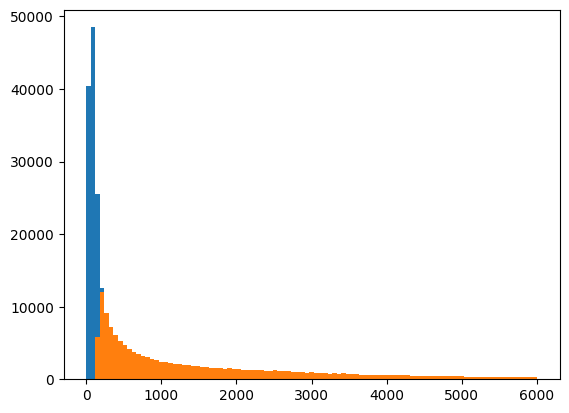

In [11]:
plt.hist( theta0_G[:,0], bins=np.linspace(0,6000, 100) )
plt.hist( theta0_G[:,1], bins=np.linspace(0,6000, 100) )

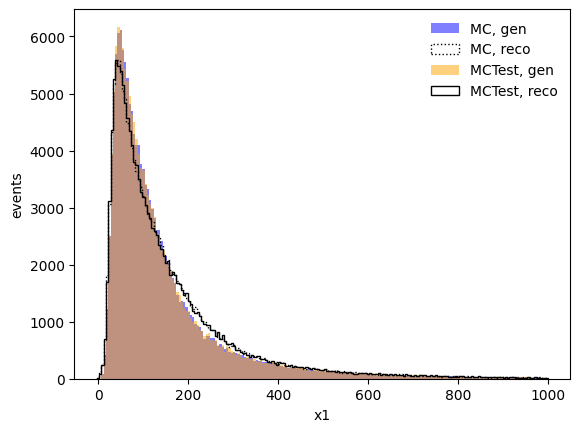

In [12]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta0_S[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="MCTest, reco")
plt.xlabel("x1")
plt.ylabel("events")
plt.legend(frameon=False)


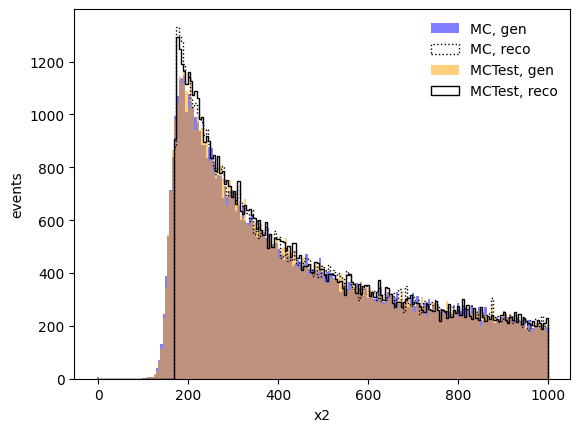

In [13]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta0_S[:,1],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:, 1],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta_unknown_S[:, 1],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="MCTest, reco")
plt.xlabel("x2")
plt.ylabel("events")
plt.legend(frameon=False)


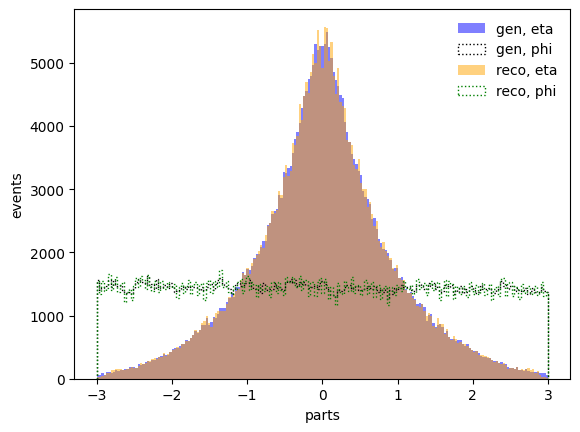

In [18]:
_,_,_=plt.hist(jet_geneta[:,0],bins=np.linspace(-3,3,200),color='blue',alpha=0.5,label="gen, eta")
_,_,_=plt.hist(jet_genphi[:,0],bins=np.linspace(-3,3,200),histtype="step",color='black',ls=':',label="gen, phi")
_,_,_=plt.hist(jet_recoeta[:,0],bins=np.linspace(-3,3,200),color='orange',alpha=0.5,label="reco, eta")
_,_,_=plt.hist(jet_recophi[:,0],bins=np.linspace(-3,3,200),histtype="step",color='green',ls=':',label="reco, phi")
#_,_,_=plt.hist(jet_genmass[:],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
#_,_,_=plt.hist(jet_genpt[:],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("parts")
plt.ylabel("events")
plt.legend(frameon=False)

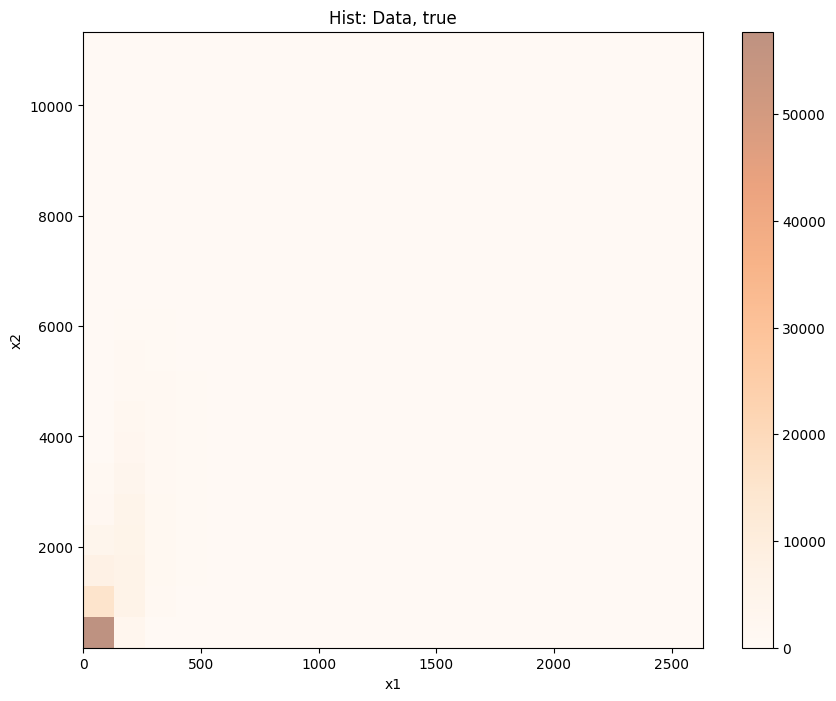

In [19]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(theta_unknown_S[:, 0], theta_unknown_S[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hist: Data, true")
plt.show()

In [20]:
# #Data, true
# theshape=theta_unknown_S.shape
# print(theshape)
# N = theshape[0] * theshape[1]
# plt.figure(figsize=(10, 8))
# plt.hist(theta_unknown_S.reshape(N), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.show()

In [21]:
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# _, _, _ = plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()


In [22]:
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2024-04-25 10:47:30.376736: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 10:47:30.377346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
myweights = of.omnifold(theta0,theta_unknown_S,20,model)

theta0G (150396, 2), labels (150396,), labels unknown (150396,), theta 0(150396, 2, 2), theta unknown s(150396, 2)


2024-04-25 10:48:17.026438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:48:17.772201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:48:21.436005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:48:21.639040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:48:22.013075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:48:59.292632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:48:59.484547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:48:59.858109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:49:03.648621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:49:03.843834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:49:04.227398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:49:41.609538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:49:41.813383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:49:42.243591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:49:46.008948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:49:46.189057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:49:46.625669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:50:24.194455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:50:24.402221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:50:24.920497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:50:28.773823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:50:28.955648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:50:29.409552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:51:06.901872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:07.111288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:07.611287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:51:11.442855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:11.636808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:12.154520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:51:49.462424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:49.658459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:50.175667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:51:54.051355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:54.232578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:51:54.809134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:52:32.393346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:52:32.602221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:52:33.196352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:52:37.074897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:52:37.269342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:52:37.888564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:53:15.259604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:53:15.475883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:53:16.139059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:53:20.192548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:53:20.416032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:53:21.082608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:53:58.957055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:53:59.163483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:53:59.849522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:54:03.788715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:54:03.970876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:54:04.630199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:54:42.262246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:54:42.443278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:54:43.063980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:54:47.044940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:54:47.227367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:54:47.852541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:55:25.231443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:55:25.424066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:55:26.047172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:55:30.010619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:55:30.197803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:55:30.818276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:56:08.466638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:08.656659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:09.329534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:56:13.399982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:13.588723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:14.337147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:56:51.961397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:52.177241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:52.868848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:56:56.961357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:57.151538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:56:57.985265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:57:35.557343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:57:35.770303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:57:36.670786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:57:40.964910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:57:41.151795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:57:42.066419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:58:20.451072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:58:20.658966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:58:21.640913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:58:25.913198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:58:26.108830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:58:27.075050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:59:04.691904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:04.886785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:05.822962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:59:10.108089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:10.293774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:11.229543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 10:59:49.116860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:49.328718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:50.299749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 10:59:54.621386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:54.810094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 10:59:55.761547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 11:00:33.547848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:00:33.745960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:00:34.733897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 11:00:39.062221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:00:39.250989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:00:40.195689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 11:01:17.979387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:01:18.191266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:01:19.175836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 11:01:23.517923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:01:23.707574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:01:24.645722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 11:02:02.661843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:02:02.860744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:02:03.814066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 2ms/step


2024-04-25 11:02:08.218094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:02:08.406761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-25 11:02:09.287309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2024-04-25 11:02:47.222811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [24]:
# #needless
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()

In [31]:
#print("Shape theta0_G:", theta0_G.shape)
#print("Shape weights:", myweights.shape)


AttributeError: no field named 'shape'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/awkward/highlevel.py#L1124)

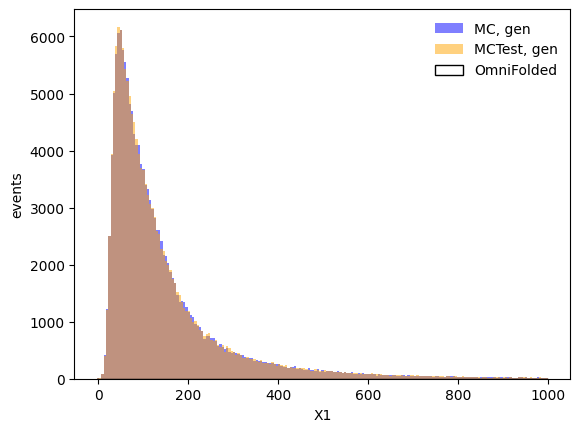

In [25]:
 _,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
#_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,1000,200),color=['green'],alpha=0.5,label="got")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

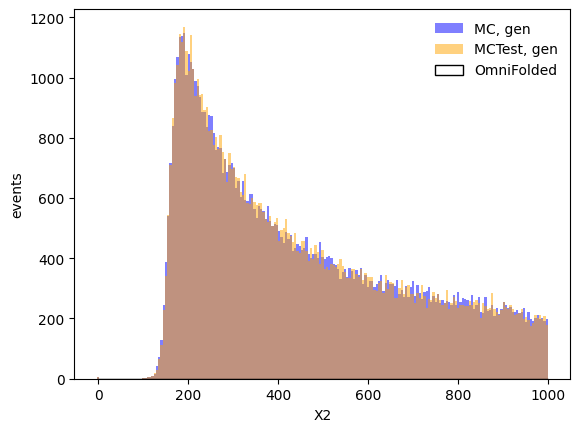

In [26]:
 _,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),color=['blue'],alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta_unknown_G[:,1],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

In [21]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,0],theta_unknown_G[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()

In [22]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,1],theta_unknown_G[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()